<h1>Simple Image Recognition Using MNIST Dataset</h1>

In this notebook, I look to train a ML model in order to identify MNIST images with different amounts of noise added to them.

The first step is to import the required modules:

In [1]:
# Matplotlib and Numpy
import matplotlib.pyplot as plt
import numpy as np

# TensorFlow and keras modules
import tensorflow as tf
import keras
import keras.layers
import keras.datasets.mnist

Below is a function that was written with the purpose to add random noise to each pixed of MNIST images.

In order for to do this, the MINIST dataset must be first loaded in:

In [2]:
# Loading MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalising pixel data
train_images = train_images/255
test_images = test_images/255

# Checking structure of dataset
print("Shape of training images:",train_images.shape)
print("Length of training set labels:",len(train_labels))
print("First label:",train_labels[0])
print("Shape of testing images:",test_images.shape)
print("Length of testing set labels:",len(test_labels))

Shape of training images: (60000, 28, 28)
Length of training set labels: 60000
First label: 5
Shape of testing images: (10000, 28, 28)
Length of testing set labels: 10000


In [3]:
def addRandomNoise(image,yNoise):
    '''
    Function that adds random noise to pixels in an input image
    
    Args:
        image (numpy.ndarray):  Input image array
        yNoise (float):         Maximum noise value that can be added to a pixel

    Returns:
        noisyImageNorm:         Input image with noise added, where that value of pixel is normalised to be between 0 and 1
    '''
    # Initialising noisy array where a random noise is applied to each index
    noise = np.random.uniform(0,yNoise,size=image.shape)
    
    # Adding noise array values to rescaled original image pixel values, then rescaling the resulting noisy image
    noisyImage = ((image) + noise)
    noisyImageNorm = noisyImage / np.max(noisyImage)
    
    return noisyImageNorm


The code cell below calls the 'addRandomNoise' function written above for the following cases on the 1st image of the 'training' MNIST dataset:

- Original, unscaled image
- Scaled image, with no noise
- Scaled image, with noise ($y_{noise}$ parameter in the function is set to 1)
- Scaled image, with noise ($y_{noise}$ parameter in the function is set to 2)
- Scaled image, with noise ($y_{noise}$ parameter in the function is set to 4)

and then plots a heatmap image of the resulting data.

*This is purely for demonstration purposes

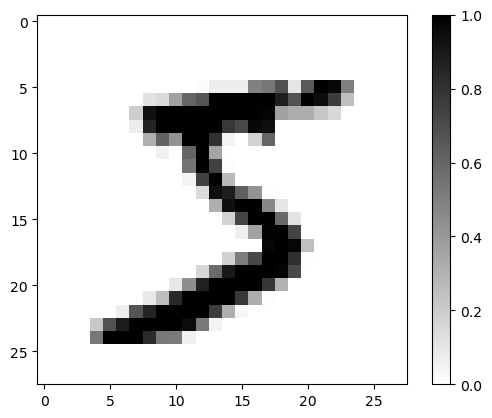

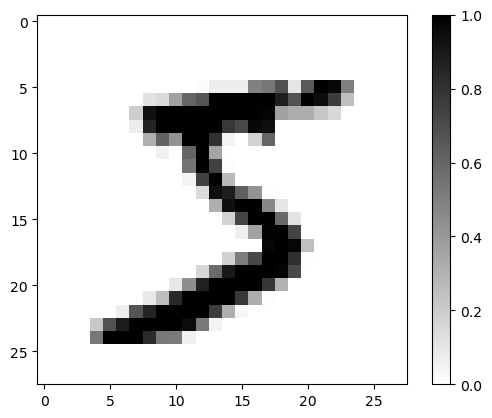

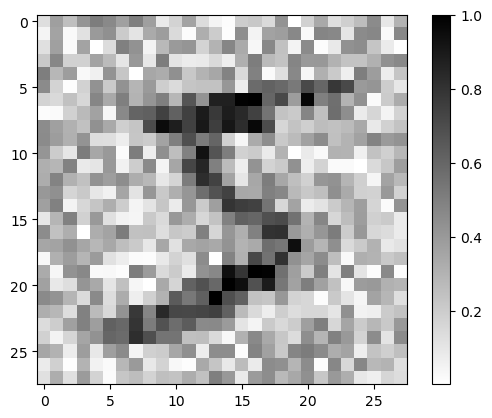

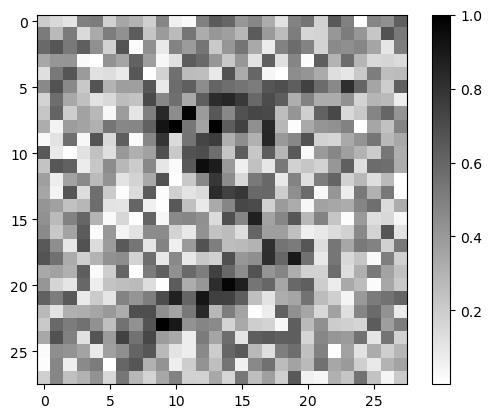

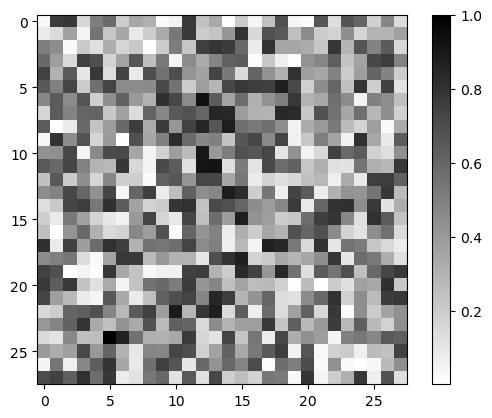

In [4]:
### For test purposes only
plt.imshow(train_images[0],cmap='binary')                     # original, unscaled image
plt.colorbar()
plt.show()
plt.imshow(addRandomNoise(train_images[0],0),cmap='binary')   # scaled image, no noise
plt.colorbar()
plt.show()
plt.imshow(addRandomNoise(train_images[0],1),cmap='binary')   # scaled image, with y_noise = 1
plt.colorbar()
plt.show()
plt.imshow(addRandomNoise(train_images[0],2),cmap='binary')   # scaled image, with y_noise = 2
plt.colorbar()
plt.show()
plt.imshow(addRandomNoise(train_images[0],4),cmap='binary')   # scaled image, with y_noise = 4
plt.colorbar()
plt.show()

Next, I will build a neural network (NN) using Keras.

The first part of this involves setting up the layers of said network:

The NN consists of a first layer with 784 (28x28) input nodes, where each node represents a pixel in the input image. The second layer is a dense layer consisting of 128 nodes. The final layer, which is the output layer, consists of 10 output nodes that correspond to the numbers 0 through 9; this represents the model's prediction of what number is shown on the provided test image.

Following the construction of the NN, I then compile the model. This allows for the following to be determined:
- Loss function (how the model is performing)
- Optimiser (how the model learns/updates itself) - I have used the 'adam' optimiser as opposed to the 'SGD' optimiser. This is because from testing, I found that the 'adam' optimiser enables the NN to reach acceptible accuracy is far fewer epochs.
- Metric (the accuracy of the model)

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',
              metrics=['accuracy'])

#model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(lr=1.0),
#              metrics=['accuracy'])

The code cell below, when run, trains the model with the training dataset using the following parameters:
- Batch size = 100
- Epochs = 3

In [6]:
history=model.fit(train_images, train_labels,batch_size=100, epochs=5)

Epoch 1/5
600/600 [==============================] - 1s 1ms/step - loss: 0.3342 - accuracy: 0.9084
Epoch 2/5
600/600 [==============================] - 1s 1ms/step - loss: 0.1519 - accuracy: 0.9568
Epoch 3/5
600/600 [==============================] - 1s 1ms/step - loss: 0.1070 - accuracy: 0.9689
Epoch 4/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0813 - accuracy: 0.9768
Epoch 5/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0662 - accuracy: 0.9810


Looking at the output above, it is clear that the NN has an acceptable performance (>95% accuracy) from after the 1st epoch. This is initially a good sign, however more investigation would be required to determine whether the model is overfitted to the training sample or not.

I will now create a function in the cell below to test the accuracy of the trained model by running the model with the test image dataset with different levels of noise added to the images (41 different levels of noise, linearly spaced between 0 and 4):

In [7]:
def NNAccuracy(testIMG,testLABELS,model,yNoiseMax=4,numNoiseParams=41):
    '''
    Function that evaluates the accuracy of a neural network model
    on test images with varying levels of random noise.

    Parameters:
        testIMG (numpy.ndarray):    Test images to evaluate the model on
        testLABELS (numpy.ndarray): Corresponding labels for the test images
        model (tf.keras.Model):     The neural network model that is evaluated
        yNoiseMax (float):          (Default = 4) Maximum amplitude of the random noise
        numNoiseParams (int):       (Default = 41) Number of different noise levels to evaluate

    Returns:
        results (numpy.ndarray):    Array containing the accuracy of the model for increasing levels of noise
        noiseLVL (numpy.ndarray):   Array containing the corresponding levels of noise applied to the test images
    '''
    
    # Holds values of noise that will be added to test images via calling 'addRandomNoise'
    noiseLVL = np.linspace(0,yNoiseMax,numNoiseParams)
      
    # Empty array that holds the values of how accurate the model is with the test data for increasing lvls of noise
    results = []
    
    for i in noiseLVL:
        
        # Adding noise to the test images
        noisyTestIMG = addRandomNoise(testIMG[:],i)
        
        # Evaluating model performance on noisy test images
        _,accuracy = model.evaluate(noisyTestIMG,testLABELS,verbose=2)
        
        results = np.append(results,accuracy)
    
    return results,noiseLVL

In [8]:
# Calling the function defined in the cell above with the neccessary input args
accuracy,noiseValues = NNAccuracy(test_images,test_labels,model)

313/313 - 0s - loss: 0.0880 - accuracy: 0.9720 - 183ms/epoch - 584us/step
313/313 - 0s - loss: 0.1109 - accuracy: 0.9677 - 132ms/epoch - 422us/step
313/313 - 0s - loss: 0.2476 - accuracy: 0.9249 - 130ms/epoch - 415us/step
313/313 - 0s - loss: 0.5846 - accuracy: 0.7875 - 140ms/epoch - 448us/step
313/313 - 0s - loss: 1.0663 - accuracy: 0.6729 - 139ms/epoch - 444us/step
313/313 - 0s - loss: 1.6201 - accuracy: 0.5859 - 130ms/epoch - 417us/step
313/313 - 0s - loss: 2.1568 - accuracy: 0.5172 - 126ms/epoch - 402us/step
313/313 - 0s - loss: 2.6865 - accuracy: 0.4581 - 124ms/epoch - 398us/step
313/313 - 0s - loss: 3.1714 - accuracy: 0.4060 - 126ms/epoch - 404us/step
313/313 - 0s - loss: 3.6238 - accuracy: 0.3583 - 126ms/epoch - 401us/step
313/313 - 0s - loss: 4.0373 - accuracy: 0.3221 - 124ms/epoch - 396us/step
313/313 - 0s - loss: 4.4408 - accuracy: 0.2848 - 125ms/epoch - 399us/step
313/313 - 0s - loss: 4.8156 - accuracy: 0.2551 - 125ms/epoch - 398us/step
313/313 - 0s - loss: 5.1550 - accuracy

The code cell below is then used to plot the accuracy (outputted above) of the model as the noise in the test images is increased.

*Note: The noise values added to the test images are linearly spaced values starting from 0 (original test images) and 4 (high noise added)

Text(0, 0.5, 'Accuracy')

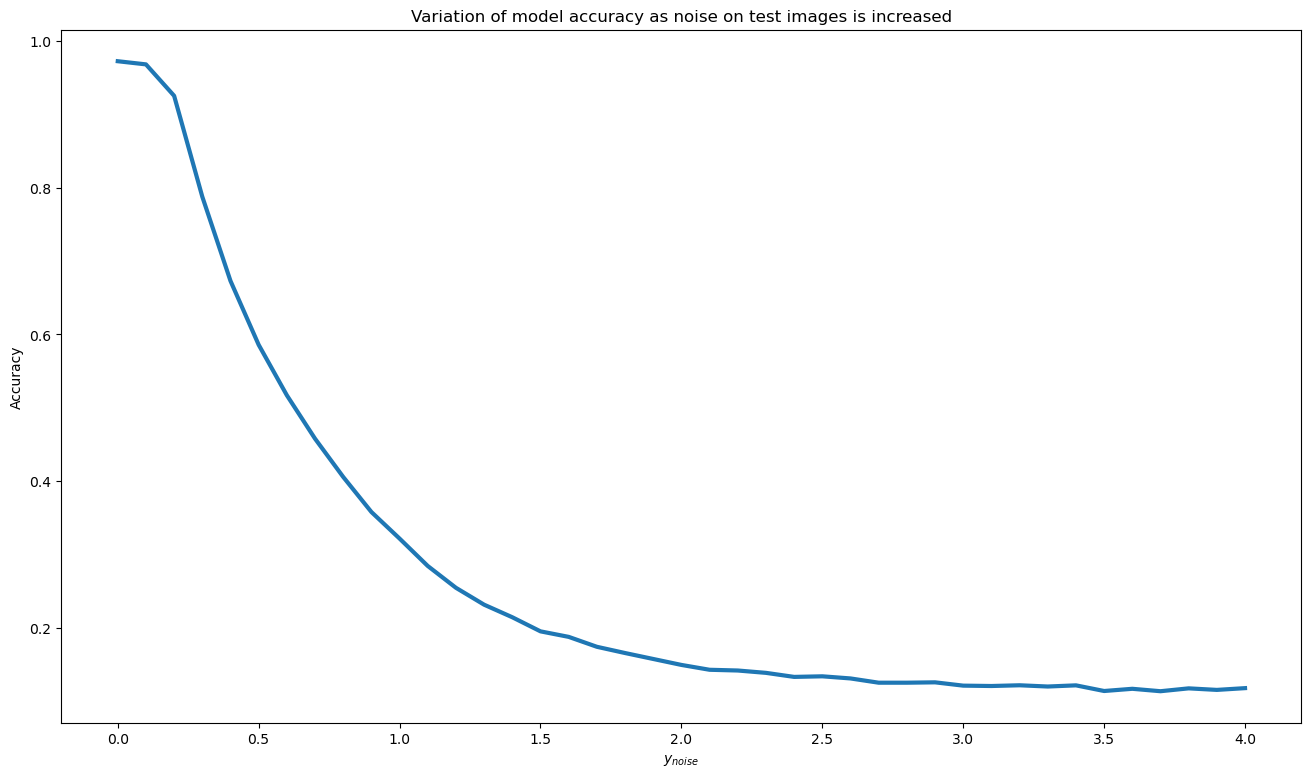

In [9]:
# Plotting the result of accuracy vs img noise
plt.figure(figsize=(16,9))
plt.plot(noiseValues,accuracy,lw=3)

# labeling figure
plt.title('Variation of model accuracy as noise on test images is increased')
plt.xlabel('$y_{noise}$')
plt.ylabel('Accuracy')

As shown by the figure above, the accuracy of the model (trained on images with no noise) performs with high accuracy for test images with no noise, however as the noise levels of the test images is increased, the accuracy of the model dwindles.

This is to be expected, given that the model was trained on data with no noise.

As part of a further investigation, in the cell below, I have written a function that retrains the model 5 times, where each time the model is trained using the training sample images with an increasing amount of noise (the $y_{noise}$ values the model was trained on were: [0, 0.25, 0.5, 0.75, 1]). Then similary to before, for each 'level of noise' the model is trained on, its accuracy is tested using the test image sample with increasing levels of noise:

In [10]:
def noiseTrainedNNAccuracy(trainingIMG,trainingLABELS,testIMG,testLABELS,noiseMAX=1):
    '''
    Function that evaluate the accuracy of a neural network model trained on
    training images with increasing levels of noise as the noise of the test images is increased

    Parameters:
        trainingIMG (numpy.ndarray):    Training images with labels to train the model
        trainingLABELS (numpy.ndarray): Corresponding labels for the training images
        testIMG (numpy.ndarray):        Test images to evaluate the model on
        testLABELS (numpy.ndarray):     Corresponding labels for the test images
        noiseMAX (float):               (Default = 1) Maximum amplitude of the random noise applied to training images

    Returns:
        results (list):                 List containing numpy arrays of accuracy values for each noise level the model is trained on
    '''
    
    # Initialising array which holds noise values that will be applied to the training images
    trainingNoise = np.linspace(0,noiseMAX,5)
    
    # Init array that will hold accuracy values from each test
    results = []
    
    for i,noiseVal in enumerate(trainingNoise):
        
        # Adding noise to training images, which increases with each iteration of the for loop
        noisyTrainingIMG = addRandomNoise(trainingIMG,noiseVal)
        
        # Retraining the model (starting from random weights each time)
        model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28,28)),
            keras.layers.Dense(128,activation='relu'),
            keras.layers.Dense(10)
        ])
        
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',
              metrics=['accuracy'])

        model.fit(noisyTrainingIMG, trainingLABELS,batch_size=100, epochs=5)
        
        # Testing the accuracy of this model by calling 'NNAccuracy' function from above
        accuracy,_ = NNAccuracy(testIMG,testLABELS,model)
        
        # Adding accuracy data for each model to 'results' list
        results.append(np.array(accuracy))
    
    return results

In [11]:
accuracy = noiseTrainedNNAccuracy(train_images,train_labels,test_images,test_labels)

Epoch 1/5
600/600 [==============================] - 1s 1ms/step - loss: 0.3332 - accuracy: 0.9065
Epoch 2/5
600/600 [==============================] - 1s 1ms/step - loss: 0.1547 - accuracy: 0.9556
Epoch 3/5
600/600 [==============================] - 1s 1ms/step - loss: 0.1084 - accuracy: 0.9685
Epoch 4/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0824 - accuracy: 0.9761
Epoch 5/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0662 - accuracy: 0.9807
313/313 - 0s - loss: 0.0799 - accuracy: 0.9753 - 167ms/epoch - 534us/step
313/313 - 0s - loss: 0.1397 - accuracy: 0.9603 - 122ms/epoch - 391us/step
313/313 - 0s - loss: 0.4487 - accuracy: 0.8351 - 123ms/epoch - 393us/step
313/313 - 0s - loss: 0.9817 - accuracy: 0.7259 - 124ms/epoch - 397us/step
313/313 - 0s - loss: 1.5081 - accuracy: 0.6539 - 123ms/epoch - 394us/step
313/313 - 0s - loss: 1.9549 - accuracy: 0.6027 - 123ms/epoch - 392us/step
313/313 - 0s - loss: 2.3448 - accuracy: 0.5536 - 123ms/epoch 

The following code cell is used to plot the accuracy of the models against $y_{noise}$ applied to test image sample.

The resulting figure is shown after the code cell.

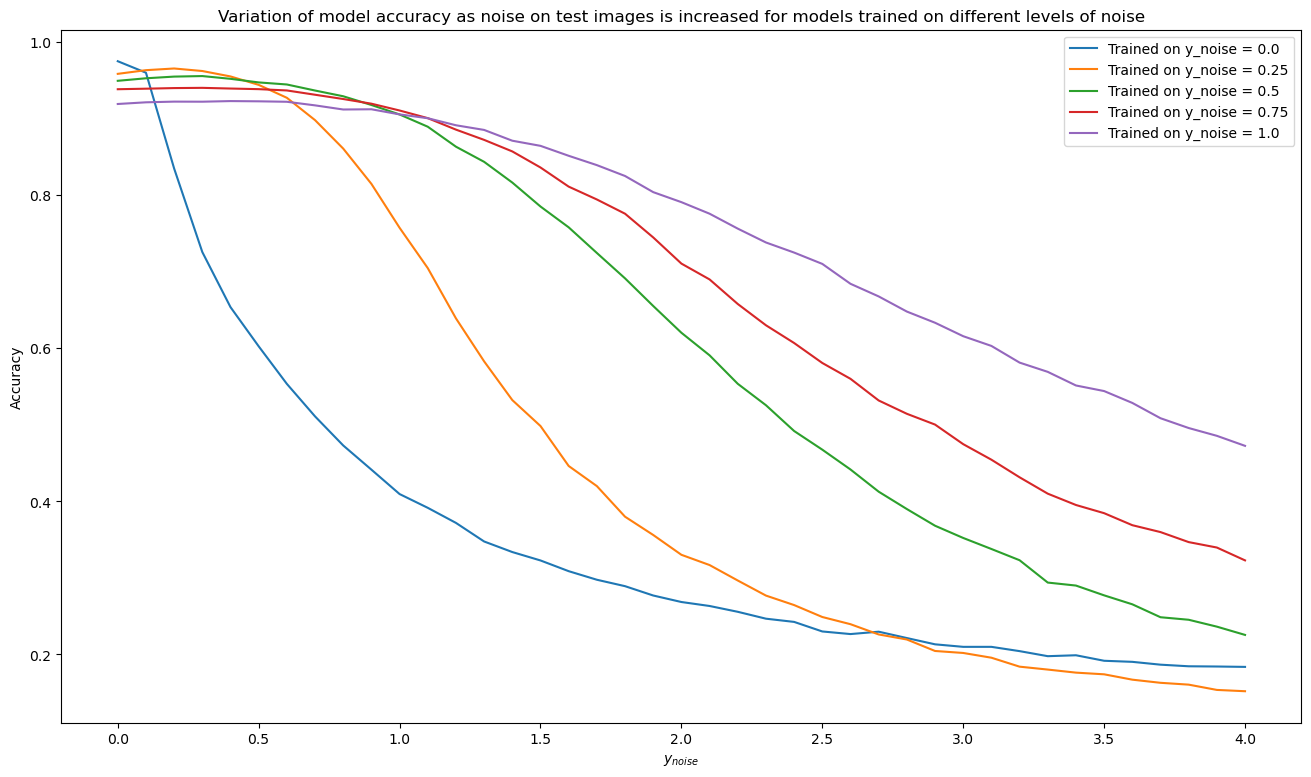

In [12]:
# Initialising figure
plt.figure(figsize=(16,9))

# labeling figure
plt.title('Variation of model accuracy as noise on test images is increased for models trained on different levels of noise')
plt.xlabel('$y_{noise}$')
plt.ylabel('Accuracy')

# For plotting the legend
traininglist=np.linspace(0,2,9)

for i in range((numNoiseTrainedModels:=len(accuracy))):  # numNoiseTrainedModels = number of models trained with different levels of noise
    
    # Plotting the result of accuracy vs img noise
    plt.plot(noiseValues,accuracy[i],label=(f'Trained on y_noise = {traininglist[i]}'))
    
plt.legend()

In order to determine the best level of noise to add to the dataset in order to maximise the performance of the image recognition model, there are are couple of factors to consider:
- Accuracy
- How the model generalises outside of the noise value it was trained in

By consolidating the figure above, it is clear that the model trained on images with zero noise is inadequate for reaching maximum performance. This 'version' of the model does in fact have the highest peak accuracy (which occurs at the value of $y_{noise}$ it was trained on, that being 0) however, the model does not generalise well when noise is added to the images it is tested with (shown by the immediate drop-off of accuracy when noise is introduced to the test image dataset).

The models trained on $y_{noise}$ values of 0.75 and 1.0 do genralise well (better than the others) over a wide range of noise values added, but it is also obvious that both models suffer with accuracy (outside the accepted range of >95%), even with zero to low-noise images. A potential reason for this might be to due with the fact that during training, the models pick up on patterns that are associated with high noise data and update themselves accordingly. Then when it comes to image recognition of low-noise images, the patterns it trained itself on are not present, hence the low performance. It is worth noting that the performance of all the models when presented with high-noise data (~$y_{noise}$ ≥ 2) is expected to fall off (significantly) given that in this regime, the images start to become increasingly unintelligible, even to a human.

For the models that are trained on images with $y_{noise}$ of 0.25 and 0.5, it is clear when looking at the figure above, the peak accuracies achieved, appear very near/at these values. This is expected, as the models should perform the best at the values of $y_{noise}$ added to training images they were trained on. Both of these models do generalise reasonably well for low to mid values of $y_{noise}$ added to the test images, however as expected, the accuracy severly falls off (more so for the model trained on the 0.25 model) for mid to high $y_{noise}$ values added.

In order to determine a specific 'best-value' of noise to add to the training data in which to train the model on, the model would have to be trained on a range of values of $y_{noise}$ between 0.25 and 0.5, where further analysis of the test data obtained would be required. Howver, depending on the required use case, any of these models might be appropriate.